In [2]:
pip install kagglehub

     |████████████████████████████████| 51 kB 851 kB/s             
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub  # Kaggle 데이터 다운로드 모듈
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Kaggle 데이터셋 다운로드 및 경로 설정    
data_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
data_dir = os.path.join(data_path, "chest_xray", "train")  # 학습 데이터 경로

# 데이터 전처리 및 증강 함수
def prepare_data(data_dir, img_size=(150, 150), batch_size=32, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,  # ResNet용 전처리
            rotation_range=30,  # 회전 범위
            width_shift_range=0.2,  # 가로 이동 범위
            height_shift_range=0.2,  # 세로 이동 범위
            shear_range=0.2,  # 전단 변환 범위
            zoom_range=0.2,  # 확대/축소 범위
            horizontal_flip=True,  # 수평 반전 허용
            validation_split=0.2,  # 검증 데이터 비율
        )
    else:
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,  # ResNet용 전처리
            validation_split=0.2,  # 검증 데이터 비율
        )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,  # 이미지 크기 변경
        batch_size=batch_size,  # 배치 크기
        class_mode="binary",  # 이진 분류
        subset="training",  # 학습 데이터로 사용
    )

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,  # 이미지 크기 변경
        batch_size=batch_size,  # 배치 크기
        class_mode="binary",  # 이진 분류
        subset="validation",  # 검증 데이터로 사용
    )

    return train_generator, validation_generator

In [11]:
# 클래스 분포 시각화
def plot_class_distribution(generator):
    labels = generator.classes
    class_counts = np.bincount(labels)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_counts, color="skyblue")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

In [12]:
# 데이터 샘플 시각화
def plot_sample_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype(np.uint8))
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.show()

In [13]:
# 기본 CNN 모델 정의
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),  # 첫 번째 합성곱 층
        MaxPooling2D(2, 2),  # 최대 풀링 층
        Conv2D(64, (3, 3), activation="relu"),  # 두 번째 합성곱 층
        MaxPooling2D(2, 2),  # 최대 풀링 층
        Conv2D(128, (3, 3), activation="relu"),  # 세 번째 합성곱 층
        MaxPooling2D(2, 2),  # 최대 풀링 층
        Flatten(),  # 평탄화
        Dense(256, activation="relu"),  # 완전 연결 층
        Dropout(0.5),  # 드롭아웃으로 과적합 방지
        Dense(1, activation="sigmoid"),  # 출력층 (이진 분류)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Adam 옵티마이저 사용
        loss="binary_crossentropy",  # 이진 분류 손실 함수
        metrics=["accuracy"],  # 평가 지표: 정확도
    )
    return model

In [14]:
# ResNet-18 모델 정의
def build_resnet18_model(input_shape):
    base_model = ResNet50(
        include_top=False,  # ResNet의 완전 연결층 제거
        weights="imagenet",  # ImageNet 가중치 사용
        input_shape=input_shape
    )

    for layer in base_model.layers[:-10]:
        layer.trainable = False  # 하위 레이어 고정

    x = Flatten()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [15]:
# 모델 학습 및 평가
def train_and_evaluate(model, train_generator, validation_generator, epochs=10):
    history = model.fit(
        train_generator, validation_data=validation_generator, epochs=epochs  # 학습 실행
    )

    return history

In [16]:
# 모델 성능 시각화
def plot_performance(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

In [17]:
# 메인 함수
def main():
    img_size = (150, 150)  # 입력 이미지 크기
    batch_size = 32  # 배치 크기
    input_shape = (*img_size, 3)  # 입력 이미지 형상

    # 데이터셋 준비 (증강 없이)
    print("Preparing data without augmentation...")
    train_gen_base, val_gen_base = prepare_data(data_dir, img_size, batch_size, augment=False)

    # 데이터셋 준비 (증강 포함)
    print("Preparing data with augmentation...")
    train_gen_aug, val_gen_aug = prepare_data(data_dir, img_size, batch_size, augment=True)

    # 기본 CNN 모델 학습 (증강 없이)
    print("Training CNN Model without augmentation")
    cnn_model_base = build_cnn_model(input_shape)
    cnn_history_base = train_and_evaluate(cnn_model_base, train_gen_base, val_gen_base, epochs=10)
    plot_performance(cnn_history_base, "CNN Model (No Augmentation)")

    # 기본 CNN 모델 학습 (증강 포함)
    print("Training CNN Model with augmentation")
    cnn_model_aug = build_cnn_model(input_shape)
    cnn_history_aug = train_and_evaluate(cnn_model_aug, train_gen_aug, val_gen_aug, epochs=10)
    plot_performance(cnn_history_aug, "CNN Model (With Augmentation)")

    # ResNet-18 모델 학습
    print("Training ResNet-18 Model")
    resnet18_model = build_resnet18_model(input_shape)
    resnet18_history = train_and_evaluate(resnet18_model, train_gen_aug, val_gen_aug, epochs=10)
    plot_performance(resnet18_history, "ResNet-18 Model")

Preparing data without augmentation...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Preparing data with augmentation...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Training CNN Model without augmentation
Epoch 1/10
131/131 [==============================] - 53s 402ms/step - loss: 5.2678 - accuracy: 0.8509 - val_loss: 0.1469 - val_accuracy: 0.9482
Epoch 2/10
131/131 [==============================] - 52s 397ms/step - loss: 0.1514 - accuracy: 0.9473 - val_loss: 0.1543 - val_accuracy: 0.9434
Epoch 3/10
131/131 [==============================] - 52s 397ms/step - loss: 0.1164 - accuracy: 0.9590 - val_loss: 0.1258 - val_accuracy: 0.9549
Epoch 4/10
131/131 [==============================] - 52s 396ms/step - loss: 0.0955 - accuracy: 0.9645 - val_loss: 0.1601 - val_accuracy: 0.9406
Epoch 5/10
131/131 [==============================] - 52s 397ms/step - loss: 0.0768 - accuracy: 0.9734 - val_loss: 0.0971 - val_accuracy:

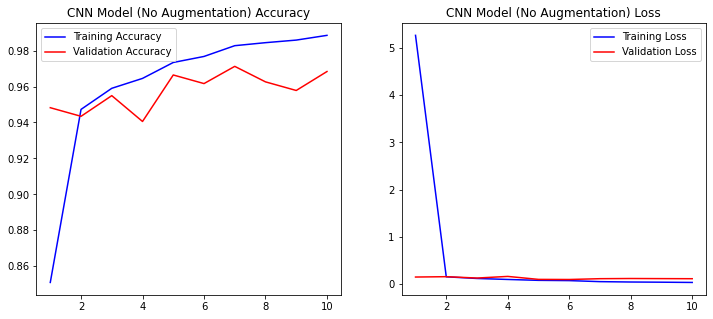

Training CNN Model with augmentation
Epoch 1/10
131/131 [==============================] - 73s 553ms/step - loss: 4.2329 - accuracy: 0.7052 - val_loss: 0.5784 - val_accuracy: 0.7593
Epoch 2/10
131/131 [==============================] - 72s 547ms/step - loss: 0.5204 - accuracy: 0.7642 - val_loss: 0.3786 - val_accuracy: 0.8293
Epoch 3/10
131/131 [==============================] - 72s 550ms/step - loss: 0.4057 - accuracy: 0.8236 - val_loss: 0.3034 - val_accuracy: 0.8552
Epoch 4/10
131/131 [==============================] - 72s 549ms/step - loss: 0.3511 - accuracy: 0.8517 - val_loss: 0.2986 - val_accuracy: 0.8725
Epoch 5/10
131/131 [==============================] - 72s 549ms/step - loss: 0.3339 - accuracy: 0.8601 - val_loss: 0.3085 - val_accuracy: 0.8495
Epoch 6/10
131/131 [==============================] - 72s 550ms/step - loss: 0.3063 - accuracy: 0.8660 - val_loss: 0.2619 - val_accuracy: 0.8917
Epoch 7/10
131/131 [==============================] - 72s 549ms/step - loss: 0.2690 - accurac

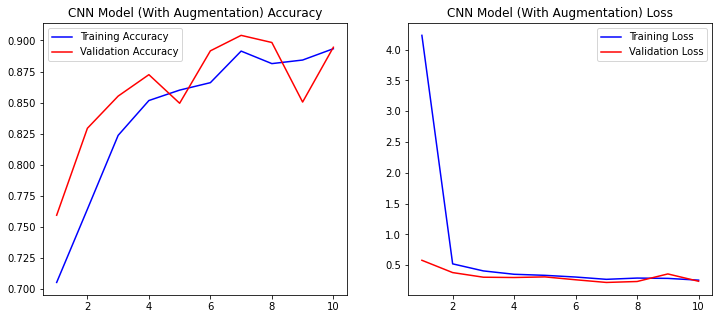

Training ResNet-18 Model
94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/10
131/131 [==============================] - 77s 569ms/step - loss: 0.9078 - accuracy: 0.9044 - val_loss: 0.3998 - val_accuracy: 0.9089
Epoch 2/10
131/131 [==============================] - 74s 563ms/step - loss: 0.1555 - accuracy: 0.9451 - val_loss: 0.2231 - val_accuracy: 0.9051
Epoch 3/10
131/131 [==============================] - 74s 563ms/step - loss: 0.1401 - accuracy: 0.9473 - val_loss: 0.1181 - val_accuracy: 0.9559
Epoch 4/10
131/131 [==============================] - 74s 563ms/step - loss: 0.1176 - accuracy: 0.9590 - val_loss: 0.1094 - val_accuracy: 0.9549
Epoch 5/10
131/131 [==============================] - 74s 563ms/step - loss: 0.1127 - accuracy: 0.9617 - val_loss: 0.1715 - val_accuracy: 0.9444
Epoch 6/10
131/131 [==============================] - 73s 561ms/step - loss: 0.1142 - accuracy: 0.9641 - val_loss: 0.1015 - val_accuracy: 0.9616
Epoch 7/10
131/131 [====================

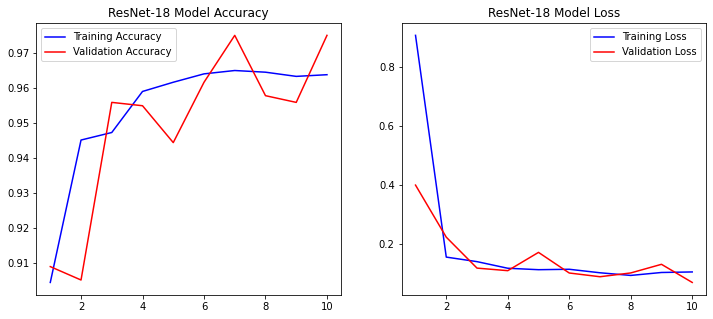

In [18]:
main()

# 목차 및 회고

## 코더 : 강민성

### 1. 데이터셋 다운로드 및 전처리
폐렴 환자와 정상인의 X-ray 영상 데이터셋은 Kaggle 데이터셋을 활용하였습니다.
그 후 데이터셋 전처리를 진행하였습니다.
### 2. 모델 구현 및 모델 성능 시각화
main함수에 포함시켜 main함수를 실행시켰을 때 정확도와 손실을 확인할 수 있는 그래프를 시각화하였습니다.
### 3. 메인 함수
기본 CNN 모델을 augmentation 증강이 되었을 때와 안 되었을 때를 분리시켜 각각 성능을 확인할 수 있게 구현하였습니다.
그리고 Resnet-18 모델을 구현하였습니다.
### 4. 회고
오늘은 메인 퀘스트 3을 진행하였습니다. 수업이 끝나고도 오류가 계속되고 정확도와 로스가 향상되지 않는 등의 문제가 발생하여 결국 항복을 선언하고 GPT의 도움을 받았습니다.. 새벽 1시까지 붙잡고 있었는데 GPT가 뚝딱 해결하는 모습을 보니 많은 생각이 들었습니다. 아쉬운 점은 제가 구현하였을 때에는 X-ray 영상을 시각화하여 어떤 이미지가 데이터셋에 포함되어 있는지 확인할 수 있었는데, 이번 코드에서는 그래프만 시각화되어있어 수정하고 싶었지만 시간 상 무리일 것 같아 일단 제출을 택하였습니다. 이번 메인 퀘스트를 진행하며 느낀 점은 본격적으로 실생활에 도입될 수 있는 프로젝트를 직접 진행한 것 같아 코딩의 세계에 이제 들어온 기분이었습니다. 더 열심히 해야겠습니다.
